In [2]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import sqlite3

In [3]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [4]:
path_to_db = '/Users/romina/Databases/aflw/data/aflw.sqlite'
path_to_imgs = '/Users/romina/Databases/aflw/data/flickr/'
path_to_positives = '/Users/romina/Documents/Masters/pos_training/'
path_to_tmp = '/Users/romina/Documents/Masters/tmp/'

In [5]:
conn = sqlite3.connect(path_to_db)
c = conn.cursor()
c.execute("""select Faces.face_id, Faces.file_id,x,y,w,h
from FacePose 
join Faces on FacePose.face_id = Faces.face_id
join FaceRect on FacePose.face_id = FaceRect.face_id
where abs(FacePose.yaw * 180/3.14159) <= 10
and abs(FacePose.roll * 180/3.14159) <= 20
and abs(FacePose.pitch * 180/3.14159) <= 20
        LIMIT 100""")
results = c.fetchall()

In [6]:
print(results[0:5])

[(39355, 'image00144.jpg', 160, 223, 645, 645), (39379, 'image00347.jpg', 463, 28, 471, 471), (39480, 'image01120.jpg', 179, -18, 268, 268), (39484, 'image01243.jpg', 92, 72, 421, 421), (39547, 'image01828.jpg', 270, 113, 686, 686)]


In [7]:
len(results)

100

In [8]:
fname_index = 1 
x_index = 2
y_index = 3
width_index = 4
height_index = 5

In [9]:
np.array(results[3][x_index:height_index+1],dtype=np.float32).reshape(-1,2)

array([[  92.,   72.],
       [ 421.,  421.]], dtype=float32)

In [10]:
def show_bbs(image, bb):
    """show image with bounding box"""
    plt.imshow(image)
    plt.scatter([bb[0], bb[0], bb[0]+bb[2], bb[0]+bb[2]], [bb[1],bb[1]+bb[3],bb[1],bb[1]+bb[3]],marker='.', c='r')
    plt.pause(0.001)

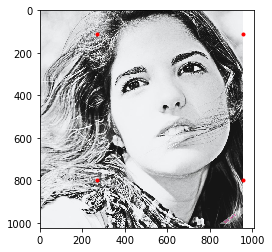

In [11]:
i = 4
plt.figure()
show_bbs(io.imread(os.path.join(path_to_tmp, results[i][fname_index])),(results[i][x_index],results[i][y_index],results[i][width_index],results[i][height_index]))
plt.show()

results = (face_id, face_index, bounding box coords)

In [62]:
class FaceBBsDataset(Dataset):
    """Face bounding boxes dataset"""
    def __init__(self, results, root_dir, transform_pos=None, transform_neg=None):
        """
        Args:
            results(list of tuples): see above for format
            root_dir(string): dir with all images
        """
        self.image_bbs= results
        self.root_dir = root_dir
        self.transform_pos = transform_pos
        self.transform_neg = transform_neg
        
    def __len__(self):
        return len(self.image_bbs)*2
    
    def __getitem__(self, idx_original):
        print('idx_original',idx_original)
        if idx_original >= len(self.image_bbs): idx = idx_original - len(self.image_bbs)
        else: idx = idx_original
        print('idx',idx)
        img_name = os.path.join(self.root_dir, self.image_bbs[idx][fname_index])
        
        try:
            image = io.imread(img_name)
            bbs = np.array(self.image_bbs[idx][x_index:height_index+1],dtype=np.float32)
            bbs.reshape(-1,2)

            sample = {'image':image, 'bb': bbs}

            if idx_original < len(self.image_bbs):
                if self.transform_pos:
                    sample = self.transform_pos(sample)
            else:
                if self.transform_neg:
                    sample = self.transform_neg(sample)

            return sample
        except:
            blank_image = np.zeros((10,10,3), np.uint8)
            sample = {'image': blank_image, 'bb': (0,0,0,0)}
            return sample

idx_original 5
idx 5


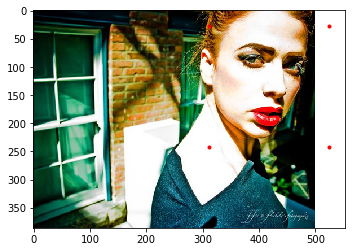

In [63]:
frontal_dataset = FaceBBsDataset(results, root_dir=path_to_tmp)
fig = plt.figure() 
# for i in range(len(frontal_dataset)):
sample = frontal_dataset[5]
show_bbs(sample['image'], sample['bb'])
    

0 (1024, 767, 3) (4,)
1 (643, 1024, 3) (4,)
2 (281, 500, 3) (4,)
3 (800, 534, 3) (4,)


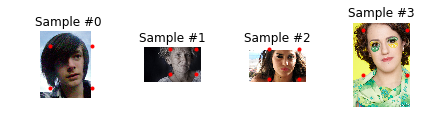

In [24]:
fig = plt.figure()
for i in range(len(frontal_dataset)):
    sample = frontal_dataset[i]
    print(i,sample['image'].shape, sample['bb'].shape)
    
    ax = plt.subplot(1,4,i+1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_bbs(**sample)
    
    if i == 3:
        plt.show()
        break

In [25]:
def iou(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    xB = min(boxA[0]+boxA[2], boxB[0]+boxB[2])
    
    yA = max(boxA[1], boxB[1])
    yB = min(boxA[1]+boxA[2], boxB[1]+boxB[2])
    
    # compute the area of intersection rectangle
    interArea = abs((xB - xA + 1) * (yB - yA + 1))
    #     print(interArea)
    
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = boxA[2] * boxA[3]
    boxBArea = boxB[2] * boxB[3]
    #     print(boxAArea)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    
    # return the intersection over union value
    return iou


In [26]:
class CropFace(object):
    """Crops region containing face in an image in a sample
        Args:
            output_size(tuple or int): desired output size"""
#     def __init__(self):
#         assert isinstance(output_size, (int,tuple))
#         if isinstance(output_size, int):
#             self.output_size = (output_size, output_size)
#         else:
#             assert len(output_size) == 2
#             self.output_size = output_size
    
    def __call__(self, sample):
        image, bb = sample['image'], sample['bb']
        h, w = int(bb[3]), int(bb[2])
        left, top = int(max(bb[0],0)), int(max(bb[1],0))
        
        face = image[top: top + h, left: left + w]
        
        return {'x': face, 'y': 1} 
        

In [27]:
class RandomNonFaceCrop(object):
    """crop a random part of image that is < 0.3 
    IOU with face"""
#     def __init__(self):
    def __call__(self,sample):
        image, bb = sample['image'], sample['bb']
        im_h, im_w = image.shape[:2]
        face_h, face_w = int(bb[3]), int(bb[2])
        
        top = np.random.randint(0, im_h - face_h)
        left = np.random.randint(0, im_w - face_w)
    
        comp = iou(bb, (top,left,face_w,face_h))
        count = 0
        while comp > 0.3 and count <= 5:
            top = np.random.randint(0, im_h - face_h)
            left = np.random.randint(0, im_w - face_w)
            comp = iou(bb, (top,left,face_w,face_h))
            count += 1
        
        if comp > 0.3 and count > 5:
            image_cropped = image[top: top + face_h, left: left + face_w]
            return {'x': image_cropped, 'y': 1}
        elif comp < 0.3:
            image_cropped = image[top: top + face_h, left: left + face_w]
            return {'x': image_cropped, 'y': 0}
        

In [28]:
class Rescale(object):
    """rescale image in sample to a given size
    args:
        output_size (tuple or int)"""
    
    def __init__(self,output_size):
        assert isinstance(output_size, (int,tuple))
        self.output_size = output_size
        
    def __call__(self,sample):
        x, y = sample['x'], sample['y']
        h, w = x.shape[:2]
        
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(x, (new_h, new_w))
        return {'x': img, 'y': y}

In [38]:
class ToTensor(object):
    """convert ndarrays in sample to Tensors"""
    def __call__(self,sample):
        x, y = sample['x'], sample['y']
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        
        #not face
        if y == 0: y_new = np.array([0, 1])
        #face
        if y == 1: y_new = np.array([1, 0])
            
        image = x.transpose((2, 0, 1))
        return {'x': torch.from_numpy(image),
                'y': torch.from_numpy(y_new)}

In [30]:
crop_face = CropFace()
crop_nonface = RandomNonFaceCrop()
scale = Rescale(100)
composed_f = transforms.Compose([CropFace(), Rescale(100)])
composed_n = transforms.Compose([RandomNonFaceCrop(), Rescale(100)])

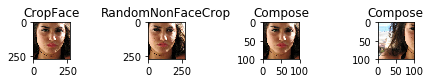

In [189]:
fig = plt.figure()
sample = frontal_dataset[2]
show_bbs(sample['image'], sample['bb'])
for i, tsfrm in enumerate([crop_face, crop_nonface, composed_f, composed_n]):
#     print(transformed_sample.keys())
#     print(sample.keys())
    transformed_sample = tsfrm(sample)
#     print(transformed_sample)
#     print(sample)
    ax = plt.subplot(1,4,i+1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    plt.imshow(transformed_sample['x'])
plt.show()

In [64]:
transformed_dataset_face = FaceBBsDataset(results, 
                                     root_dir=path_to_tmp,
                                    transform_pos=transforms.Compose([
                                        CropFace(), 
                                        Rescale((224,224)),
                                        ToTensor()
                                    ]),
                                    transform_neg=transforms.Compose([
                                        RandomNonFaceCrop(), 
                                        Rescale((224,224)),
                                        ToTensor()
                                    ]))
transformed_dataset_nonface = FaceBBsDataset(results, 
                                     root_dir=path_to_tmp,
                                    transform_pos=transforms.Compose([
                                        RandomNonFaceCrop(), 
                                        Rescale((224,224)),
                                        ToTensor()
                                    ]))

In [65]:
print(len(transformed_dataset_face))
# print(len(transformed_dataset_nonface))

200


In [48]:
for i in range(20,len(transformed_dataset_face)):
    try:
        sample = transformed_dataset_face[i]
        print(i,sample['x'].size(), sample['y'])
        if i == 6:
            break
    except:
        print('oops')

idx_original 20
idx 20
20 torch.Size([3, 224, 224]) 
 1
 0
[torch.LongTensor of size 2]

idx_original 21
idx 21
21 torch.Size([3, 224, 224]) 
 1
 0
[torch.LongTensor of size 2]

idx_original 22
idx 22
22 torch.Size([3, 224, 224]) 
 1
 0
[torch.LongTensor of size 2]

idx_original 23
idx 23
23 torch.Size([3, 224, 224]) 
 1
 0
[torch.LongTensor of size 2]

idx_original 24
idx 24
24 torch.Size([3, 224, 224]) 
 1
 0
[torch.LongTensor of size 2]

idx_original 25
idx 25
25 torch.Size([3, 224, 224]) 
 1
 0
[torch.LongTensor of size 2]

idx_original 26
idx 26
26 torch.Size([3, 224, 224]) 
 1
 0
[torch.LongTensor of size 2]

idx_original 27
idx 27
27 torch.Size([3, 224, 224]) 
 1
 0
[torch.LongTensor of size 2]

idx_original 28
idx 28
28 torch.Size([3, 224, 224]) 
 1
 0
[torch.LongTensor of size 2]

idx_original 29
idx 29
29 torch.Size([3, 224, 224]) 
 1
 0
[torch.LongTensor of size 2]

idx_original 30
idx 30
30 torch.Size([3, 224, 224]) 
 1
 0
[torch.LongTensor of size 2]

idx_original 31
idx 3

116 torch.Size([3, 224, 224]) 
 0
 1
[torch.LongTensor of size 2]

idx_original 117
idx 17
oops
idx_original 118
idx 18
118 torch.Size([3, 224, 224]) 
 0
 1
[torch.LongTensor of size 2]

idx_original 119
idx 19
119 torch.Size([3, 224, 224]) 
 0
 1
[torch.LongTensor of size 2]

idx_original 120
idx 20
120 torch.Size([3, 224, 224]) 
 0
 1
[torch.LongTensor of size 2]

idx_original 121
idx 21
121 torch.Size([3, 224, 224]) 
 0
 1
[torch.LongTensor of size 2]

idx_original 122
idx 22
122 torch.Size([3, 224, 224]) 
 0
 1
[torch.LongTensor of size 2]

idx_original 123
idx 23
123 torch.Size([3, 224, 224]) 
 0
 1
[torch.LongTensor of size 2]

idx_original 124
idx 24
124 torch.Size([3, 224, 224]) 
 0
 1
[torch.LongTensor of size 2]

idx_original 125
idx 25
125 torch.Size([3, 224, 224]) 
 0
 1
[torch.LongTensor of size 2]

idx_original 126
idx 26
126 torch.Size([3, 224, 224]) 
 0
 1
[torch.LongTensor of size 2]

idx_original 127
idx 27
127 torch.Size([3, 224, 224]) 
 0
 1
[torch.LongTensor of siz

In [30]:
for i in range(len(transformed_dataset_nonface)):
    sample = transformed_dataset_nonface[i]
    print(i,sample['x'].size(), sample['y'])
    if i == 6:
        break

idx 0
idx 0
0 torch.Size([3, 224, 224]) 
 1
 0
[torch.LongTensor of size 2]

idx 1
idx 1
1 torch.Size([3, 224, 224]) 
 0
 1
[torch.LongTensor of size 2]

idx 2
idx 2
2 torch.Size([3, 224, 224]) 
 0
 1
[torch.LongTensor of size 2]

idx 3
idx 3
3 torch.Size([3, 224, 224]) 
 0
 1
[torch.LongTensor of size 2]

idx 4
idx 4
4 torch.Size([3, 224, 224]) 
 1
 0
[torch.LongTensor of size 2]

idx 5
idx 5
5 torch.Size([3, 224, 224]) 
 0
 1
[torch.LongTensor of size 2]

idx 6
idx 6
6 torch.Size([3, 224, 224]) 
 0
 1
[torch.LongTensor of size 2]



In [68]:
dataloader = DataLoader(transformed_dataset_face, 
                        batch_size=4,
                       shuffle=True, num_workers=2)

idx_original 48
idx 48
idx_original 136
idx 36
idx_original 190
idx 90
idx_original 122
idx 22
idx_original 66
idx 66
idx_original 83
idx 83
idx_original 175
idx 75
idx_original 185
idx 85
idx_original 166
idx 66
idx_original 35
idx 35
idx_original 196
idx 96
idx_original 32
idx 32
idx_original 94
idx 94
idx_original 198
idx 98
0 torch.Size([4, 3, 224, 224]) torch.Size([4, 2])
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 2])
idx_original 78
idx 78
idx_original 124
idx 24
idx_original 192
idx 92
idx_original 193
idx 93
idx_original 143
idx 43
idx_original 93
idx 93
idx_original 176
idx 76
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 2])
idx_original 60
idx 60
idx_original 130
idx 30
idx_original 126
idx 26
idx_original 125
idx 25
idx_original 53
idx 53
idx_original 18
idx 18
idx_original 71
idx 71
idx_original 38
idx 38
idx_original 0
idx 0
3 torch.Size([4, 3, 224, 224]) torch.Size([4, 2])


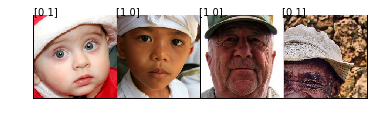

idx_original 117
idx 17
idx_original 12
idx 12


In [72]:
def show_batch(sample_batched):
    """Show image and label for a batch of samples."""
    images_batch, labels_batch = \
            sample_batched['x'], sample_batched['y']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
#         plt.label(labels_batch[i,:])
        plt.text(224*i,0.65,labels_batch[i,:].numpy())

for i_batch, sample_batched in enumerate(dataloader):
    try:
        print(i_batch, sample_batched['x'].size(),
              sample_batched['y'].size())

        # observe 4th batch and stop.
        if i_batch == 3:
            plt.figure()
            show_batch(sample_batched)
            plt.axis('off')
            plt.ioff()
            plt.show()
            break
    except:
        print('oops')